In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd

<AxesSubplot:title={'center':'percentage of bow-tie components'}>

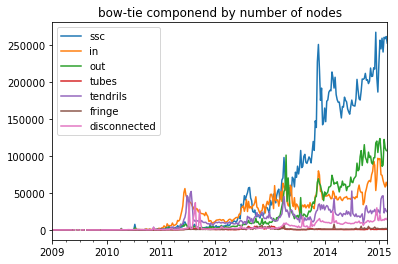

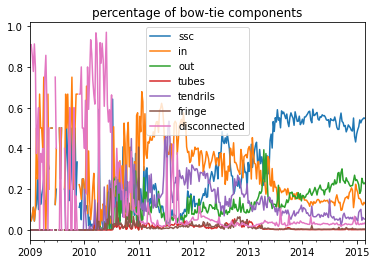

In [3]:
#plot results using the test.json

df = pd.read_json("results/btc530_week.json",convert_dates=True).transpose()
df = df.sort_index()

total_nodes = df["nodes"]
bt_components = ["ssc","in","out","tubes","tendrils","fringe","disconnected"]

#absolut number of nodes in compnents
df_comp = df.copy()[bt_components]
df_comp.plot(title="bow-tie componend by number of nodes")

#relative number of nodes in compnents
df_percent = df_comp.div(total_nodes.values,axis=0)
#df_percent.reset_index(drop=True).plot()
df_percent.plot(title="percentage of bow-tie components")

<AxesSubplot:title={'center':'number of sink?? in components'}>

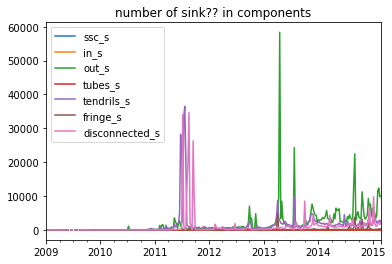

In [4]:
# plot is_sink per component absolute
df.copy()[list(map(lambda x: x +  "_s" ,bt_components))].plot(title = "number of sink?? in components")